# ML741
## Assignment 1
## K-nearest neighbours

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the CSV file
df = pd.read_excel('beans.xlsx')

#### Missing values

In [3]:
# Drop observations that have missing values for the class labels
df = df.dropna(subset=['Class'])

# Impute colour with the most frequently occuring class: brown
df_cat = df.select_dtypes(exclude=[np.number])
df[df_cat.columns] = df_cat.fillna(df.mode().iloc[0])

# Impute ShapeFactor6 with the mean
df['ShapeFactor6'] = df['ShapeFactor6'].fillna(df['ShapeFactor6'].mean())

# Impute numeric variables
df_numeric = df.select_dtypes(include=[np.number])
df[df_numeric.columns] = df_numeric.fillna(df_numeric.median())

#### Label encoding

In [135]:
# First, observe the class distributions
class_counts = df.value_counts(['Class'])
class_proportions = df.value_counts(['Class'], normalize=True)
data = {'Count': class_counts, 'Proportion': class_proportions}
class_dist = pd.DataFrame(data)
class_dist

,Count,Proportion
Class,,
DERMASON,3542,0.2605561277
SIRA,2634,0.1937619538
SEKER,2025,0.1489627777
HOROZ,1927,0.1417537149
CALI,1628,0.1197587171
BARBUNYA,1317,0.0968809769
BOMBAY,521,0.0383257319


In [5]:
# Encode the categorical variables to be numeric

from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
df['Colour'] = le1.fit_transform(df['Colour'])
class_mapping1 = dict(zip(le1.classes_, le1.transform(le1.classes_)))
for original, encoded in class_mapping1.items():
    print(f"{original}: {encoded}")
    
le2 = LabelEncoder()
df['Class'] = le2.fit_transform(df['Class'])
class_mapping2 = dict(zip(le2.classes_, le2.transform(le2.classes_)))
for original, encoded in class_mapping2.items():
    print(f"{original}: {encoded}")

0: 0
1: 1
2: 2
3: 3
BARBUNYA: 0
BOMBAY: 1
CALI: 2
DERMASON: 3
HOROZ: 4
SEKER: 5
SIRA: 6


### PCA to visualise the data

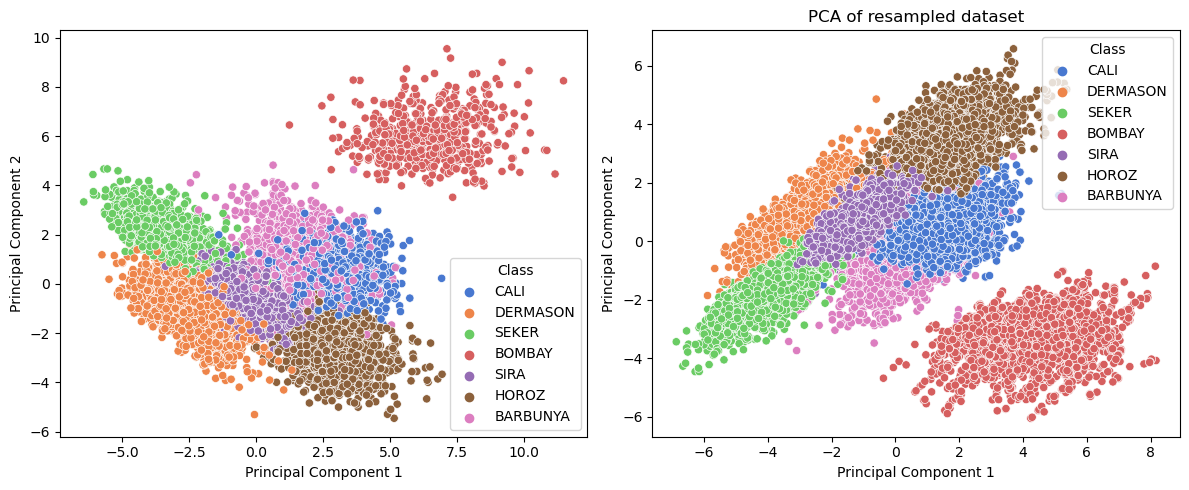

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

X = df.drop(columns=['Class'])
y = df['Class']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_resampled_scaled = scaler.fit_transform(X_resampled)

pca1 = PCA(n_components=2).fit_transform(X_scaled)
pca2 = PCA(n_components=2).fit_transform(X_resampled_scaled)

pca_df = pd.DataFrame(data=pca1, columns=['PC1', 'PC2'])
pca_df['Class'] = y.reset_index(drop=True)

pca_df_2 = pd.DataFrame(data=pca2, columns=['PC1', 'PC2'])
pca_df_2['Class'] = y_resampled.reset_index(drop=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# First plot
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df, palette='muted', ax=ax1)
# ax1.set_title('PCA plot of dry beans')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
# Second plot
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df_2, palette='muted', ax=ax2)
ax2.set_title('PCA of resampled dataset')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

## K-nearest neighbours
This contains the final model

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['Class'])
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors=10, weights='uniform', p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy: {balanced_accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9708261828879627
Balanced accuracy: 0.9659297714206835
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       384
           1       1.00      1.00      1.00       170
           2       0.93      0.92      0.92       511
           3       1.00      0.99      1.00      1089
           4       1.00      0.99      1.00       593
           5       0.99      0.98      0.98       571
           6       0.96      0.98      0.97       761

    accuracy                           0.97      4079
   macro avg       0.97      0.97      0.97      4079
weighted avg       0.97      0.97      0.97      4079



### Grid search with SMOTE and k-fold cross-validation

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

def custom_grid_search_with_smote(X, y, model, param_grid, cv=5, scoring='accuracy'):
    """
    Custom grid search with SMOTE applied only to training folds.
    
    Parameters:
    X : array-like of shape (n_samples, n_features)
        The input samples.
    y : array-like of shape (n_samples,)
        The target values.
    model : estimator object
        The model to be tuned.
    param_grid : dict
        Dictionary with parameters names as keys and lists of parameter settings to try as values.
    cv : int, default=5
        Number of folds for cross-validation.
    scoring : str, default='accuracy'
        Scoring metric to use. Currently only supports 'accuracy'.
    
    Returns:
    best_params : dict
        Best parameters found.
    best_score : float
        Mean cross-validated score of the best estimator.
    """
    
    best_score = -np.inf
    best_raw_score = -np.inf
    best_params = {}
    
    # Create cross-validation splits
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Iterate over all combinations of parameters
    for params in _param_grid_to_list(param_grid):
        scores = []
        raw_scores = []
        
        # Perform cross-validation
        for train_index, val_index in skf.split(X, y):
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
            
            # Apply SMOTE to the training data
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
            
            # Train the model
            model.set_params(**params)
            model.fit(X_train_resampled, y_train_resampled)
            
            # Evaluate on validation set
            y_pred = model.predict(X_val_fold)
            score = balanced_accuracy_score(y_val_fold, y_pred)
            raw_score = accuracy_score(y_val_fold, y_pred)
            scores.append(score)
            raw_scores.append(raw_score)
        
        # Calculate mean score for this parameter combination
        mean_score = np.mean(scores)
        mean_raw_score = np.mean(raw_scores)
#         print(f"accuracy: {mean_score}")
        
        # Update best parameters if we have a new best score
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            
        if mean_raw_score > best_raw_score:
            best_raw_score = mean_raw_score
    
    return best_params, best_score, best_raw_score

def _param_grid_to_list(param_grid):
    """Helper function to convert param_grid to a list of dictionaries."""
    import itertools
    
    keys = param_grid.keys()
    values = param_grid.values()
    combinations = itertools.product(*values)
    return [dict(zip(keys, combo)) for combo in combinations]


# Usage:
from sklearn.tree import DecisionTreeClassifier

X_mine = df.drop(columns=['Class'])
y_mine = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mine) # scale all the data
X_scaled = pd.DataFrame(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = KNeighborsClassifier()
param_grid = {
    "n_neighbors": [1,2,3,5,10],
    "p": [1,2], # manhattan or euclidean distance
    "weights": ['uniform','distance']
}

# best score is BALANCED accuracy
# best raw score in RAW ACCURACY

best_params, best_score, best_raw_score = custom_grid_search_with_smote(X_train, y_train, model, param_grid)
print(f"Best parameters: {best_params}")
print(f"Best cross-validation balanced accuracy: {best_score}")
print(f"Best cross-validation overall accuracy: {best_raw_score}")

Best parameters: {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
Best cross-validation balanced accuracy: 0.9673760579831496
Best cross-validation overall accuracy: 0.9713084603258013
